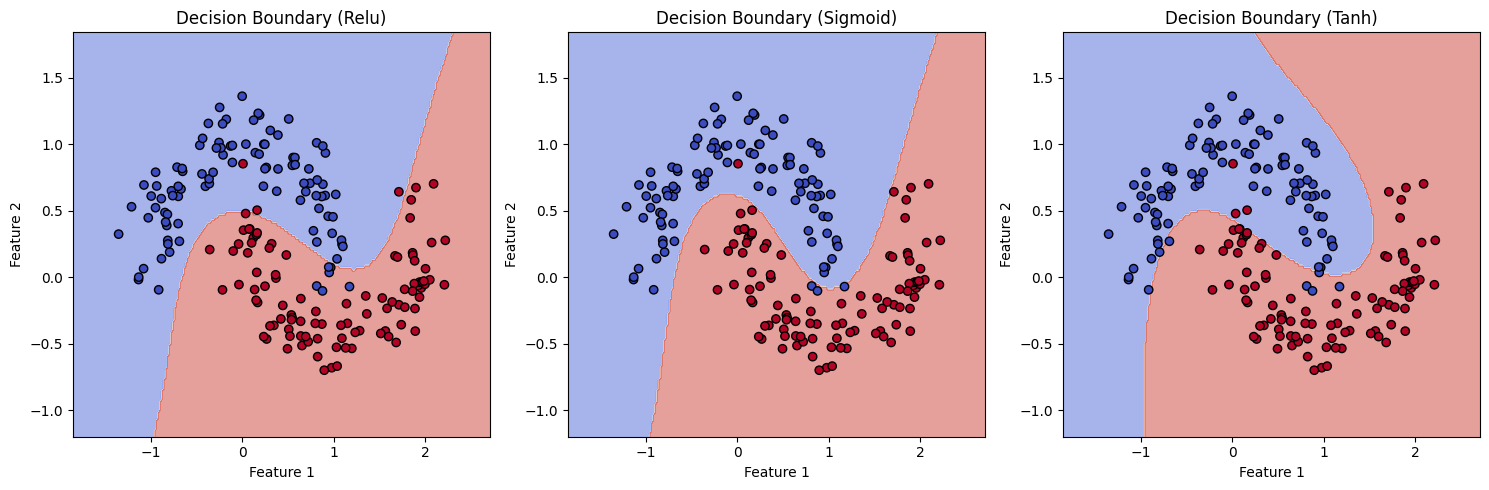

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

# 1. Generate roughly half-moon shaped dataset
X_raw, y_raw = make_moons(n_samples=200, noise=0.15, random_state=42)
Y = y_raw.reshape(-1, 1)

# 2. Apply feature engineering to make it curved separable by a single neuron
# Expanding features up to 3rd degree allows a linear model to fit a nonlinear curve
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_raw)


# 3. Define the specified activation functions and their derivatives
class Activations:
    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500)  # prevent overflow
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(z):
        s = Activations.sigmoid(z)
        return s * (1 - s)

    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def tanh_derivative(z):
        t = np.tanh(z)
        return 1 - t**2

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)


# 4. Single Neuron Implementation
class SingleNeuron:
    def __init__(self, n_features, activation="sigmoid"):
        np.random.seed(42)
        self.weights = np.random.randn(n_features, 1) * 0.1
        self.bias = 0.0

        self.loss_history = []
        self.acc_history = []

        if activation == "sigmoid":
            self.act_fn = Activations.sigmoid
            self.act_deriv = Activations.sigmoid_derivative
        elif activation == "tanh":
            self.act_fn = Activations.tanh
            self.act_deriv = Activations.tanh_derivative
        elif activation == "relu":
            self.act_fn = Activations.relu
            self.act_deriv = Activations.relu_derivative

    def forward(self, X):
        self.z = np.dot(X, self.weights) + self.bias
        self.a = self.act_fn(self.z)
        return self.a

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        # MSE loss derivative
        dz = (self.a - y) * self.act_deriv(self.z)
        dw = (1 / m) * np.dot(X.T, dz)
        db = (1 / m) * np.sum(dz)

        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db

    def train(self, X, y, epochs=5000, lr=0.1):
        for epoch in range(epochs):
            # 1. Forward pass (predictions)
            preds_prob = self.forward(X)

            # 2. Backward pass (update weights)
            self.backward(X, y, lr)

            # 3. Calculate and store Loss (Mean Squared Error)
            loss = np.mean((preds_prob - y) ** 2)
            self.loss_history.append(loss)

            # 4. Calculate and store Accuracy
            # Note: For Tanh, threshold is 0.0. For Sigmoid/ReLU, threshold is typically 0.5.
            # We use 0.5 below, but adjust if using Tanh specifically (-1 to 1).
            preds_class = (preds_prob >= 0.5).astype(int)
            acc = np.mean(preds_class == y)
            self.acc_history.append(acc)

    def predict(self, X):
        preds = self.forward(X)
        return (preds >= 0.5).astype(int)


# 5. Train and generate the decision boundary curves
activations = ["relu", "sigmoid", "tanh"]
plt.figure(figsize=(15, 5))

for i, act in enumerate(activations):
    neuron = SingleNeuron(n_features=X_poly.shape[1], activation=act)

    # Adjust learning rate for ReLU to prevent exploding gradients
    lr = 0.01 if act == "relu" else 0.5
    neuron.train(X_poly, Y, epochs=5000, lr=lr)

    plt.subplot(1, 3, i + 1)

    # Generate grid to plot the decision boundary curves
    x_min, x_max = X_raw[:, 0].min() - 0.5, X_raw[:, 0].max() + 0.5
    y_min, y_max = X_raw[:, 1].min() - 0.5, X_raw[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_poly = poly.transform(grid)
    Z = neuron.predict(grid_poly)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, cmap="coolwarm")
    plt.scatter(
        X_raw[:, 0], X_raw[:, 1], c=Y.flatten(), cmap="coolwarm", edgecolors="k"
    )
    plt.title(f"Decision Boundary ({act.capitalize()})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

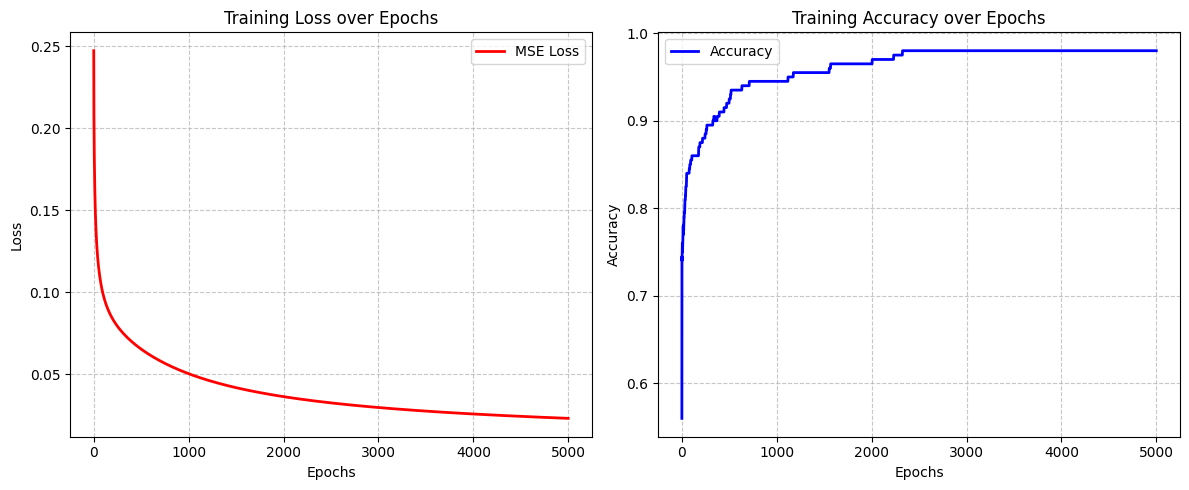

In [ ]:
# Assuming you have already initialized and trained the neuron
neuron = SingleNeuron(n_features=X_poly.shape[1], activation="sigmoid")
neuron.train(X_poly, Y, epochs=5000, lr=0.5)

# Plotting the metrics
plt.figure(figsize=(12, 5))

# 1. Plot Loss Graph
plt.subplot(1, 2, 1)
plt.plot(neuron.loss_history, label="MSE Loss", color="red", linewidth=2)
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# 2. Plot Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(neuron.acc_history, label="Accuracy", color="blue", linewidth=2)
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
neuron.acc_history[-1]

0.98